In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma']#, 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
tam_janela = n_variaveis*janela
n_entradas = n_variaveis * janela + 2 #ncont, valor e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 1

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
inputs_nao_norm = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1

#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
    
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imean ) / istd #normaliza prs
    
mini_batch_size = int(dias*batch*0.1)

C:\Users\core\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\core\Anaconda3\lib\site-packages\pandas\core\indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = 4
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        #model.add(Dense(x*3, activation='relu')) #camada escondida
        #model.add(Dense(x*2, activation='relu')) #camada escondida
        #model.add(Dense(x, activation='relu')) #camada escondida
        model.add(Dense(64, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        #sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        #model.compile(loss='mse', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(n_variaveis*janela)
        self.prox_janela_precos = np.zeros(n_variaveis*janela)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict(self.state) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size) if dias>5 else self.memory
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = self.model.predict(estado) 
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
            
        self.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo
        
    def tira_ultima_janela(self):
        if self.janela_precos.shape[0] > self.janela * self.n_variaveis:
            self.janela_precos = self.janela_precos[self.n_variaveis:] #tira os ultimos precos
    
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.next_state, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                715       
Total params: 9,611
Trainable params: 9,611
Non-trainable params: 0
_________________________________________________________________


In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def teste(preco, ncont, acao, valor, custo=0):   

    if acao == 0: #zerado
        if ncont>0:  #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        elif ncont<0: #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        else:         
            reward = 0
        valor = -100
    elif acao>0:  #comprado
        if ncont>0:
            if acao>ncont: #aumento da posicao
                reward = -custo*(acao-ncont)
                valor = (valor*ncont+(acao-ncont)*preco)/(acao)  #calculo preco medio
            elif acao<ncont:  #diminuicao da posicao
                reward = (ncont-acao)*(preco-valor) -custo*(ncont-acao)
                valor = valor #preco medio se mantem
            else:
                reward = 0
        elif ncont<0:   #trocando a mao
            reward = abs(ncont)*(valor-preco) -custo*(acao+abs(ncont))
            valor = preco
        else:          #comecou a comprar
            reward = -custo*abs(acao)
            valor = preco
    else:       #vendido
        if ncont>0:#trocando a mao
            reward = ncont*(preco-valor) -custo*(ncont+abs(acao))
            valor = preco
        elif ncont<0:
            if abs(acao)<abs(ncont): #diminuicao da posicao
                reward = (abs(ncont)-abs(acao))*(valor-preco) -custo*(abs(ncont)-abs(acao))
                valor = valor #preco medio se mantem
            elif abs(acao)>abs(ncont): #aumento da posicao
                reward = -custo*(abs(acao)-abs(ncont))
                valor = (valor*abs(ncont)+(abs(acao)-abs(ncont))*preco)/(abs(acao))  #calculo preco medio
            else: #preco medio se mantem
                reward = 0
                
    reward = ncont*acao*preco
    ncont = acao
    return ncont, reward, valor

def obter_acao():
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -100 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    lucro = 0.
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 1e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia], steps[dia+1] ):  #roda os dados
        
        modelo.state = np.reshape([ncont, step, precos['preco'][step], valor], (1,modelo.state_size))
        
        acao = obter_acao()
        ncont, reward, valor = teste(precos['preco'][step], ncont, acao, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor*pstd+pmean if valor!=-100 else 0
        #p=precos['preco'][step]*pstd+pmean
        #print("acao={0}; ncont={1}; reward={2} valor={3} preco={4}".format(acao, ncont, reward, valor, precos['preco'][step]))   

        if step == (steps[dia] - 1): #se ultimo step do dia
            done = True     
            
        modelo.next_state = np.reshape([ncont, step+1, precos['preco'][step+1], valor], (1,modelo.state_size))
        modelo.remember(acao, reward/20, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        
    #fim do dia

    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( 0, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards

indic = 0

def train_teste(batch_size=10):
        global indic
        minibatch = random.sample(modelo.memory, batch_size)
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            target = reward
            if not done:
                target = (reward + modelo.gamma * np.amax(modelo.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = modelo.model.predict(estado)
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
        
        modelo.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo

W1111 20:18:19.981703  6680 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1111 20:18:20.457582  6680 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1111 20:18:20.541562  6680 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



resultado da epoca 0 = 287.55 Epsilon = 1.000
resultado da epoca 1 = -149.44 Epsilon = 0.999
resultado da epoca 2 = -192.14 Epsilon = 0.998
resultado da epoca 3 = 97.95 Epsilon = 0.997
resultado da epoca 4 = 170.46 Epsilon = 0.996
resultado da epoca 5 = -255.78 Epsilon = 0.995
resultado da epoca 6 = 8.97 Epsilon = 0.994
resultado da epoca 7 = -54.64 Epsilon = 0.993
resultado da epoca 8 = -27.30 Epsilon = 0.992
resultado da epoca 9 = -80.49 Epsilon = 0.991
resultado da epoca 10 = 126.78 Epsilon = 0.990
resultado da epoca 11 = -23.36 Epsilon = 0.989
resultado da epoca 12 = 27.45 Epsilon = 0.988
resultado da epoca 13 = -81.33 Epsilon = 0.987
resultado da epoca 14 = -143.92 Epsilon = 0.986
resultado da epoca 15 = 123.05 Epsilon = 0.985
resultado da epoca 16 = 64.66 Epsilon = 0.984
resultado da epoca 17 = -12.60 Epsilon = 0.983
resultado da epoca 18 = -76.31 Epsilon = 0.982
resultado da epoca 19 = -93.07 Epsilon = 0.981
resultado da epoca 20 = 61.44 Epsilon = 0.980
resultado da epoca 21 = -

resultado da epoca 175 = 45.44 Epsilon = 0.827
resultado da epoca 176 = 51.75 Epsilon = 0.826
resultado da epoca 177 = 78.80 Epsilon = 0.825
resultado da epoca 178 = -25.78 Epsilon = 0.824
resultado da epoca 179 = 3.51 Epsilon = 0.823
resultado da epoca 180 = -49.56 Epsilon = 0.822
resultado da epoca 181 = -127.98 Epsilon = 0.821
resultado da epoca 182 = -19.28 Epsilon = 0.820
resultado da epoca 183 = 83.93 Epsilon = 0.819
resultado da epoca 184 = 86.63 Epsilon = 0.818
resultado da epoca 185 = 125.33 Epsilon = 0.817
resultado da epoca 186 = -60.04 Epsilon = 0.816
resultado da epoca 187 = 96.91 Epsilon = 0.815
resultado da epoca 188 = -89.34 Epsilon = 0.814
resultado da epoca 189 = 142.34 Epsilon = 0.813
resultado da epoca 190 = 70.97 Epsilon = 0.812
resultado da epoca 191 = 68.18 Epsilon = 0.811
resultado da epoca 192 = 21.98 Epsilon = 0.810
resultado da epoca 193 = 12.00 Epsilon = 0.809
resultado da epoca 194 = -111.68 Epsilon = 0.808
resultado da epoca 195 = -81.99 Epsilon = 0.807
re

resultado da epoca 349 = -224.12 Epsilon = 0.654
resultado da epoca 350 = -86.92 Epsilon = 0.653
resultado da epoca 351 = 84.49 Epsilon = 0.653
resultado da epoca 352 = 35.04 Epsilon = 0.652
resultado da epoca 353 = -39.92 Epsilon = 0.651
resultado da epoca 354 = 191.08 Epsilon = 0.650
resultado da epoca 355 = -3.29 Epsilon = 0.649
resultado da epoca 356 = 44.51 Epsilon = 0.648
resultado da epoca 357 = 308.05 Epsilon = 0.647
resultado da epoca 358 = 19.37 Epsilon = 0.646
resultado da epoca 359 = -49.58 Epsilon = 0.645
resultado da epoca 360 = 14.16 Epsilon = 0.644
resultado da epoca 361 = 91.69 Epsilon = 0.643
resultado da epoca 362 = -5.19 Epsilon = 0.642
resultado da epoca 363 = 17.37 Epsilon = 0.641
resultado da epoca 364 = 213.09 Epsilon = 0.640
resultado da epoca 365 = -68.30 Epsilon = 0.639
resultado da epoca 366 = 17.32 Epsilon = 0.638
resultado da epoca 367 = -51.01 Epsilon = 0.637
resultado da epoca 368 = 2.09 Epsilon = 0.636
resultado da epoca 369 = -86.17 Epsilon = 0.635
res

resultado da epoca 523 = -230.48 Epsilon = 0.482
resultado da epoca 524 = -202.45 Epsilon = 0.481
resultado da epoca 525 = 224.78 Epsilon = 0.480
resultado da epoca 526 = -97.37 Epsilon = 0.479
resultado da epoca 527 = -320.04 Epsilon = 0.478
resultado da epoca 528 = -254.19 Epsilon = 0.477
resultado da epoca 529 = -46.14 Epsilon = 0.476
resultado da epoca 530 = -102.22 Epsilon = 0.475
resultado da epoca 531 = -115.87 Epsilon = 0.474
resultado da epoca 532 = -92.53 Epsilon = 0.473
resultado da epoca 533 = 23.46 Epsilon = 0.472
resultado da epoca 534 = 117.55 Epsilon = 0.471
resultado da epoca 535 = -183.42 Epsilon = 0.470
resultado da epoca 536 = -25.79 Epsilon = 0.469
resultado da epoca 537 = -27.09 Epsilon = 0.468
resultado da epoca 538 = -49.47 Epsilon = 0.467
resultado da epoca 539 = -124.28 Epsilon = 0.466
resultado da epoca 540 = 90.56 Epsilon = 0.465
resultado da epoca 541 = -153.85 Epsilon = 0.464
resultado da epoca 542 = -304.65 Epsilon = 0.463
resultado da epoca 543 = 12.63 E

resultado da epoca 695 = 198.23 Epsilon = 0.312
resultado da epoca 696 = -8.65 Epsilon = 0.311
resultado da epoca 697 = -47.07 Epsilon = 0.310
resultado da epoca 698 = 54.82 Epsilon = 0.309
resultado da epoca 699 = 22.34 Epsilon = 0.308
resultado da epoca 700 = 53.75 Epsilon = 0.307
resultado da epoca 701 = 8.41 Epsilon = 0.306
resultado da epoca 702 = -74.60 Epsilon = 0.305
resultado da epoca 703 = 58.61 Epsilon = 0.304
resultado da epoca 704 = 10.53 Epsilon = 0.303
resultado da epoca 705 = -58.64 Epsilon = 0.302
resultado da epoca 706 = -25.17 Epsilon = 0.301
resultado da epoca 707 = 111.69 Epsilon = 0.300
resultado da epoca 708 = 103.45 Epsilon = 0.299
resultado da epoca 709 = 159.02 Epsilon = 0.298
resultado da epoca 710 = 28.50 Epsilon = 0.297
resultado da epoca 711 = 196.18 Epsilon = 0.296
resultado da epoca 712 = 107.47 Epsilon = 0.295
resultado da epoca 713 = 50.55 Epsilon = 0.294
resultado da epoca 714 = 10.11 Epsilon = 0.293
resultado da epoca 715 = 238.43 Epsilon = 0.292
res

resultado da epoca 869 = 25.97 Epsilon = 0.140
resultado da epoca 870 = 15.21 Epsilon = 0.139
resultado da epoca 871 = 54.85 Epsilon = 0.138
resultado da epoca 872 = -72.57 Epsilon = 0.137
resultado da epoca 873 = 105.24 Epsilon = 0.136
resultado da epoca 874 = 25.19 Epsilon = 0.135
resultado da epoca 875 = 53.49 Epsilon = 0.134
resultado da epoca 876 = 279.59 Epsilon = 0.133
resultado da epoca 877 = 176.00 Epsilon = 0.132
resultado da epoca 878 = 24.51 Epsilon = 0.131
resultado da epoca 879 = 152.58 Epsilon = 0.130
resultado da epoca 880 = 58.77 Epsilon = 0.129
resultado da epoca 881 = 72.40 Epsilon = 0.128
resultado da epoca 882 = 188.25 Epsilon = 0.127
resultado da epoca 883 = 48.33 Epsilon = 0.126
resultado da epoca 884 = 46.50 Epsilon = 0.125
resultado da epoca 885 = 149.18 Epsilon = 0.124
resultado da epoca 886 = 137.82 Epsilon = 0.123
resultado da epoca 887 = 247.69 Epsilon = 0.122
resultado da epoca 888 = 333.19 Epsilon = 0.121
resultado da epoca 889 = 339.62 Epsilon = 0.120
re

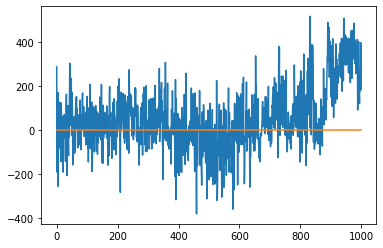

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    modelo.epsilon = 1.
    melhor_reward = 0
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
            
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            train_teste() #roda o modelo com toda a memoria da epoca
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            #print(dias_pos)
            #print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = 0
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        #print(dias_pos)
        #print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca

In [7]:
modelo.epsilon = 0
print(rodar_dias(inputs, custo))

390.1479368057737


In [8]:
np.amax(inputs['preco'])


36.16442351423735

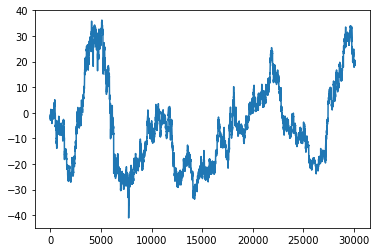

In [9]:
plt.plot(range(0,len(inputs)), inputs['preco'])

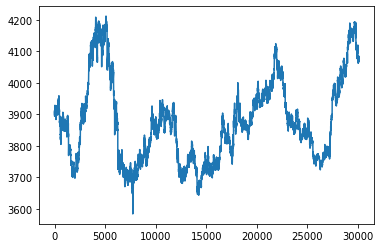

In [10]:
plt.plot(range(0,len(inputs_nao_norm)), inputs_nao_norm['preco'])